# Basic usage of cucount, together with lsstypes, for position correlations
lsstypes is accessible at https://github.com/adematti/lsstypes.

## Cutsky geometry

Let us first generate some fake data

In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

from cucount.numpy import count2, count2_analytic, Particles, BinAttrs, WeightAttrs, MeshAttrs, setup_logging
import lsstypes as types
from lsstypes import Count2, Count2Correlation

def generate_catalog(size=100, boxsize=(1000,) * 3, offset=(1000., 0., 0.), n_individual_weights=1, n_bitwise_weights=0, seed=42):
    rng = np.random.RandomState(seed=seed)
    positions = [o + rng.uniform(0., 1., size) * b for o, b in zip(offset, boxsize)]
    weights = []
    weights += [rng.uniform(0.5, 1., size) for i in range(n_individual_weights)]
    # weights = utils.pack_bitarrays(*[rng.randint(0, 2, size) for i in range(64 * n_bitwise_weights)], dtype=np.uint64)
    # weights = utils.pack_bitarrays(*[rng.randint(0, 2, size) for i in range(33)], dtype=np.uint64)
    weights += [rng.randint(0, 0xffffffff, size, dtype=np.uint64) for i in range(n_bitwise_weights)]
    #weights += [np.full(size, 0xffffffff, dtype=np.uint64) for i in range(n_bitwise_weights)]
    return np.column_stack(positions), weights

boxsize = (3000.,) * 3

# Cutsky geometry
size = int(1e6)
data_positions, data_weights = generate_catalog(size, boxsize, n_individual_weights=1, seed=42)
randoms_positions, randoms_weights = generate_catalog(2 * size, boxsize=boxsize, n_individual_weights=1, seed=84)

Then compute the pair counts and Landy-Szalay estimator

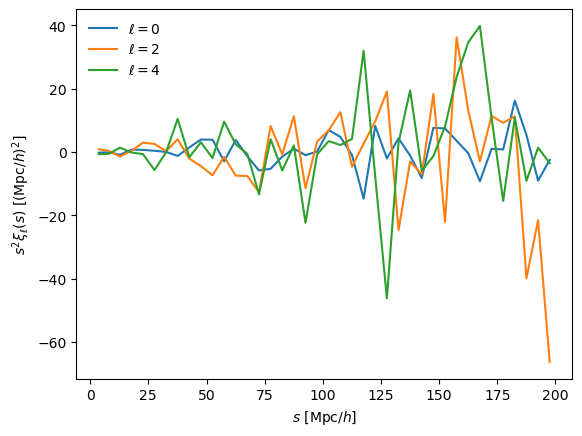

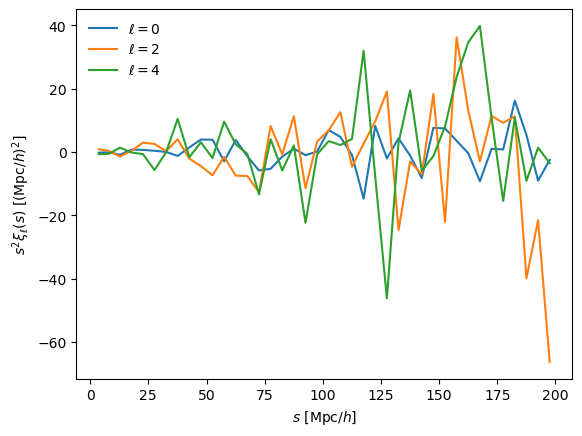

In [2]:
data = Particles(data_positions, data_weights)
randoms = Particles(randoms_positions, randoms_weights)

battrs = BinAttrs(s=np.linspace(0., 200., 201), mu=(np.linspace(-1., 1., 201), 'midpoint'))
wattrs = WeightAttrs()
# With bitwise weights, one would typically do:
# wattrs = WeightAttrs(bitwise=dict(weights=data.get('bitwise_weight'), p_correction_nbits=True))
mattrs = None

# Helper to convert to lsstypes Count2
def to_lsstypes(battrs: BinAttrs, counts: np.ndarray, norm: np.ndarray) -> Count2:
    coords = battrs.coords()
    edges = battrs.edges()
    edges = {f'{k}_edges': v for k, v in edges.items()}
    return Count2(counts=counts, norm=norm, **coords, **edges, coords=list(coords))

# Hepler to get counts as Count2
def get_counts(*particles: Particles, wattrs: WeightAttrs=None) -> Count2:
    if wattrs is None: wattrs = WeightAttrs()
    autocorr = len(particles) == 1
    counts = count2(*(particles * 2 if autocorr else particles), battrs=battrs, wattrs=wattrs, mattrs=mattrs)['weight']
    if autocorr:
        auto_sum = wattrs(*(particles * 2)).sum()
        norm = wattrs(particles[0]).sum()**2 - auto_sum
        # Correct auto-pairs
        zero_index = tuple(np.flatnonzero((0 >= edges[:, 0]) & (0 < edges[:, 1])) for edges in battrs.edges().values())
        counts[zero_index] -= auto_sum
    else:
        norm = wattrs(particles[0]).sum() * wattrs(particles[1]).sum()
    return to_lsstypes(battrs, counts, norm)

DD = get_counts(data, wattrs=wattrs)
DR = get_counts(data.clone(weights=wattrs(data)), randoms)  # clone data, with IIP weights (in case we provided bitwise weights)
RD = DR.clone(value=DR.value()[:, ::-1])  # reverse mu for RD
RR = get_counts(randoms)
# Note: you can also "sum" DR, RD and RR counts over multiple random catalogs to reduce noise
# DR = types.sum(list_of_DR_counts)
# RR = types.sum(list_of_RR_counts)

# For reconstructed 2PCF, you can provide DD, DS, SD, SS, RR counts
correlation = Count2Correlation(estimator='landyszalay', DD=DD, DR=DR, RD=RD, RR=RR)
dirname = Path('_tests')
fn = dirname / 'test_lsstypes_landyszalay.h5'
dirname.mkdir(exist_ok=True)
correlation.write(fn)

correlation = types.read(fn)

poles = correlation.select(s=slice(0, None, 5)).project(ells=[0, 2, 4])  # rebin and project
# You can write/read poles from disk
for ell in poles.ells:
    pole = poles.get(ell)
    pole.coords('s')  # coordinates
    pole.value()  # value
poles.plot(show=True)

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250526-1.0.0/conda/lib/python3.10/site-packages/numpy/lib/polynomial.py:1338: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


output size, input (theory) size: {window.shape}


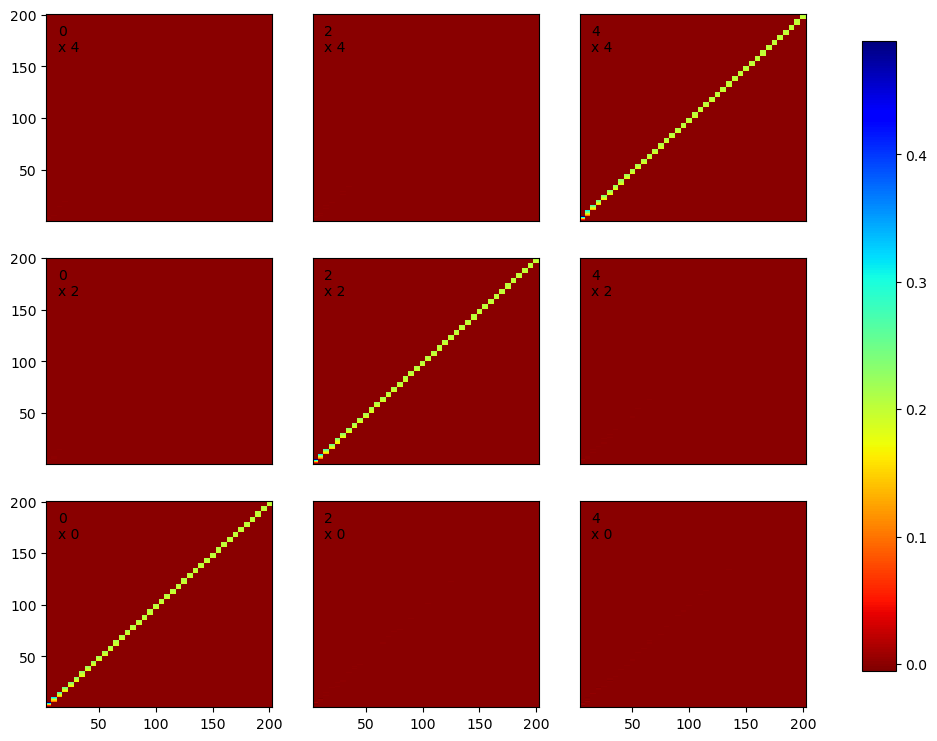

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250526-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


Text(0, 0.5, '$s^2 \\xi_\\ell(s)$ [$(\\mathrm{Mpc}/h)^{2}$]')

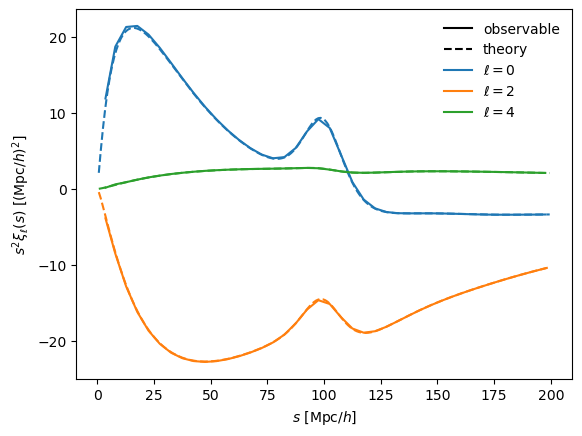

In [3]:
# To get the window/rebinning matrix (mostly diagonal)
_, window = correlation.select(s=slice(0, None, 5)).project(ells=[0, 2, 4], kw_window=dict(RR=correlation.get('RR'), resolution=1))
print('output size, input (theory) size: {window.shape}')
window.plot(show=True);

# Prepare some theory to illustrate the convolution
from cosmoprimo.fiducial import DESI
cosmo = DESI(engine='eisenstein_hu')
z = 1.
pk1d = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
s, s_edges = window.theory.get(0).coords('s'), window.theory.get(0).edges('s')
b = 1.5
beta = cosmo.growth_rate(z) / b
poles = [(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pk1d.to_xi(fftlog_kwargs={'ell': 0})(s),
           0.9 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pk1d.to_xi(fftlog_kwargs={'ell': 2})(s),
           8. / 35 * beta ** 2 * pk1d.to_xi(fftlog_kwargs={'ell': 4})(s)]
from lsstypes import Count2CorrelationPole, Count2CorrelationPoles
theory = Count2CorrelationPoles([Count2CorrelationPole(s=s, s_edges=s_edges, value=pole, ell=ell) for ell, pole in zip([0, 2, 4], poles)])

observable = window.dot(theory, zpt=False, return_type=None)  # or window.value().dot(theory.value()) for a pure numpy array operation

ax = plt.gca()
ax.plot([], [], color='k', linestyle='-', label='observable')
ax.plot([], [], color='k', linestyle='--', label='theory')
for ill, ell in enumerate(observable.ells):
    color = f'C{ill:d}'
    pole = observable.get(ell)
    ax.plot(pole.coords('s'), pole.coords('s')**2 * pole.value(), color=color, label=rf'$\ell = {ell:d}$', linestyle='-')
    pole = theory.get(ell)
    ax.plot(pole.coords('s'), pole.coords('s')**2 * pole.value(), color=color, linestyle='--')
ax.legend(frameon=False)
ax.set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
ax.set_ylabel(r'$s^2 \xi_\ell(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

## Periodic box geometry

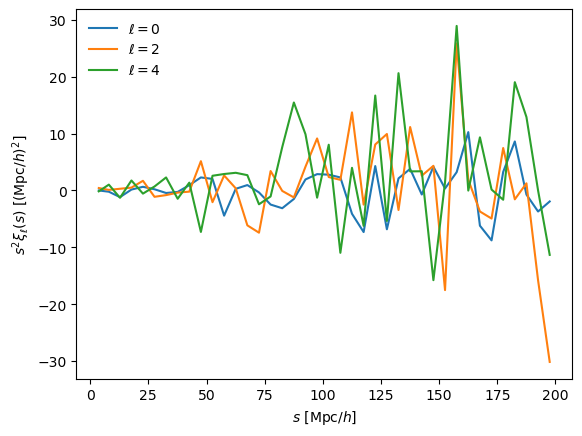

In [4]:
data_positions, data_weights = generate_catalog(int(1e6), boxsize, n_individual_weights=1, seed=42)
data = Particles(data_positions, data_weights)

battrs = BinAttrs(s=np.linspace(0., 200., 201), mu=(np.linspace(-1., 1., 201), 'x'))
wattrs = WeightAttrs()
mattrs = MeshAttrs(data, boxsize=boxsize, battrs=battrs, periodic=True)

DD = get_counts(data)
# In case of periodic geometry; analytic RR
RR = to_lsstypes(battrs, count2_analytic(battrs=battrs, mattrs=boxsize), norm=1.)
correlation = Count2Correlation(estimator='natural', DD=DD, RR=RR)
fn = dirname / 'test_lsstypes_natural.h5'
correlation.write(fn)
correlation = types.read(fn)
poles = correlation.select(s=slice(0, None, 5)).project(ells=[0, 2, 4])  # rebin and project
# You can write/read poles from disk
poles.plot(show=True);